# Exploratory Data Analysis (EDA): DEAM Dataset for Music Emotion Recognition

**Project:** Moodio - AI Music Mood Predictor
**Author:** [Andi Zulfikar]

## 1. Latar Belakang & Tujuan
Tujuan dari notebook ini adalah untuk memahami karakteristik dataset **DEAM (The MediaEval Database for Emotional Analysis in Music)**. Sebelum membangun model Deep Learning (CNN), kita perlu menjawab pertanyaan:
1. Bagaimana distribusi emosi (Valence & Arousal) dalam dataset?
2. Bagaimana struktur data labelnya? Apakah perlu transformasi?
3. Bagaimana karakteristik file audionya? (Durasi, Sample Rate).
4. Strategi preprocessing apa yang paling tepat berdasarkan temuan data?

## 2. Persiapan Library

In [14]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display
import IPython.display as ipd

# Konfigurasi Plotting agar terlihat rapi
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Path Dataset (Sesuaikan dengan lokasi di komputer Anda)
PATH_AUDIO = "../data/raw/audio" 
PATH_ANNOTATIONS = "../data/metadata/audio" # Folder berisi valence.csv dan arousal.csv

print("Libraries loaded successfully.")

Libraries loaded successfully.


## 3. Analisis Label (Valence & Arousal)
Dataset DEAM dikenal memiliki format "dynamic annotation" (per detik). Mari kita lihat struktur file CSV-nya untuk menentukan cara loading yang tepat.

In [5]:
# Load file CSV Valence dan Arousal
# Asumsi nama file dari dataset asli
df_valence = pd.read_csv(os.path.join(PATH_ANNOTATIONS, "valence.csv"))
df_arousal = pd.read_csv(os.path.join(PATH_ANNOTATIONS, "arousal.csv"))

print("Shape Valence Data:", df_valence.shape)
print("Shape Arousal Data:", df_arousal.shape)

# Mari kita intip 5 baris pertama
print("\nContoh Data Valence:")
display(df_valence.head())
display(df_arousal.head())

Shape Valence Data: (1802, 1224)
Shape Arousal Data: (1802, 1225)

Contoh Data Valence:


,song_id,sample_15000ms,sample_15500ms,sample_16000ms,sample_16500ms,sample_17000ms,sample_17500ms,sample_18000ms,sample_18500ms,sample_19000ms,...,sample_621500ms,sample_622000ms,sample_622500ms,sample_623000ms,sample_623500ms,sample_624000ms,sample_624500ms,sample_625000ms,sample_625500ms,sample_626000ms
0,2,-0.073341,-0.074661,-0.074077,-0.078154,-0.081588,-0.080873,-0.083611,-0.082145,-0.081632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,-0.189702,-0.187765,-0.183740,-0.188761,-0.193704,-0.190834,-0.189041,-0.197554,-0.202871,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,0.154286,0.148063,0.146956,0.151180,0.135942,0.076832,0.084487,0.088513,0.090944,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,0.149053,0.148260,0.147369,0.146956,0.147857,0.146927,0.145651,0.145795,0.146420,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,0.342816,0.345193,0.332023,0.328887,0.327603,0.329011,0.327883,0.334822,0.328447,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,song_id,sample_15000ms,sample_15500ms,sample_16000ms,sample_16500ms,sample_17000ms,sample_17500ms,sample_18000ms,sample_18500ms,sample_19000ms,...,sample_622000ms,sample_622500ms,sample_623000ms,sample_623500ms,sample_624000ms,sample_624500ms,sample_625000ms,sample_625500ms,sample_626000ms,sample_626500ms
0,2,-0.109386,-0.114942,-0.116413,-0.118613,-0.126457,-0.133199,-0.136855,-0.144713,-0.138985,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3,-0.110846,-0.123973,-0.131103,-0.135956,-0.140775,-0.144664,-0.163118,-0.165218,-0.158858,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4,0.222327,0.179446,0.178388,0.184056,0.176042,0.178720,0.176345,0.175793,0.176154,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5,-0.255613,-0.251579,-0.251958,-0.251124,-0.250763,-0.251957,-0.251957,-0.251957,-0.251957,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7,0.464234,0.460789,0.460991,0.461046,0.457240,0.465702,0.471809,0.469918,0.473377,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 🔍 Temuan 1: Format Data "Wide"
Data tersimpan dalam format melebar (*Wide Format*). Kolom-kolomnya merepresentasikan waktu (`sample_15000ms`, `sample_15500ms`, dst).

**Observasi Penting:**
1. **Start Time:** Data dimulai dari `sample_15000ms` (Detik ke-15). Artinya, **15 detik pertama lagu tidak memiliki label**.
   * *Keputusan:* Kita harus membuang/skip audio dari detik 0-15 saat training.
2. **Transformasi:** Format ini sulit diolah langsung. Kita perlu mengubahnya menjadi *Long Format* agar bisa digabungkan.

In [7]:
def transform_wide_to_long(df, label_name):
    # Mengubah kolom waktu menjadi baris
    df_melted = df.melt(id_vars=['song_id'], var_name='timestamp', value_name=label_name)
    
    # Membersihkan kolom timestamp (ambil angkanya saja)
    df_melted['timestamp'] = df_melted['timestamp'].str.extract('(\d+)').astype(int)
    
    return df_melted

# Transformasi
print("Sedang mentransformasi data...")
df_v_long = transform_wide_to_long(df_valence, 'valence')
df_a_long = transform_wide_to_long(df_arousal, 'arousal')

# Menggabungkan Valence dan Arousal berdasarkan Song ID dan Timestamp
df_final = pd.merge(df_v_long, df_a_long, on=['song_id', 'timestamp'])

print(f"Total Data Points setelah transformasi: {len(df_final)}")
display(df_final.head())

Sedang mentransformasi data...
Total Data Points setelah transformasi: 2203846


,song_id,timestamp,valence,arousal
0,2,15000,-0.073341,-0.109386
1,3,15000,-0.189702,-0.110846
2,4,15000,0.154286,0.222327
3,5,15000,0.149053,-0.255613
4,7,15000,0.342816,0.464234


### 🔍 Temuan Data (Update)
Setelah inspeksi awal, ditemukan beberapa karakteristik penting:
1.  **Shape Mismatch:** Jumlah kolom waktu Valence (1224) dan Arousal (1225) tidak sama. Kita perlu menyinkronkan timeline keduanya.
2.  **Missing Values (NaN):** Karena durasi lagu bervariasi, bagian akhir kolom berisi `NaN`. Ini harus dibersihkan.
3.  **Skala Nilai:** Data berisi nilai negatif (contoh: -0.18) dan positif. Ini menunjukkan data sudah dinormalisasi (Centered), bukan skala absolut 1-10.

**Strategi Cleaning:**
* Mengubah ke *Long Format* (Melt).
* Membuang baris `NaN`.
* Menggunakan `Inner Join` saat penggabungan untuk memastikan Valence dan Arousal memiliki timestamp yang sama persis.

In [6]:
def clean_and_melt(df, label_name):
    # 1. Buang kolom yang duplikat atau tidak relevan jika ada
    # (Fokus pada kolom sample_xxxxms dan song_id)
    
    # 2. Melt (Melebar ke Memanjang)
    df_melted = df.melt(id_vars=['song_id'], var_name='timestamp_str', value_name=label_name)
    
    # 3. Ekstrak angka dari string 'sample_15000ms' -> 15000
    df_melted['timestamp'] = df_melted['timestamp_str'].str.extract('(\d+)').astype(float)
    
    # 4. Konversi ms ke detik (opsional, biar lebih mudah dibaca)
    # 15000 ms = 15 detik
    # df_melted['time_sec'] = df_melted['timestamp'] / 1000.0
    
    # 5. Hapus baris yang nilainya NaN (karena durasi lagu habis)
    df_clean = df_melted.dropna(subset=[label_name])
    
    # 6. Hapus kolom string bantuan
    df_clean = df_clean.drop(columns=['timestamp_str'])
    
    return df_clean

print("1. Memproses Valence...")
df_v_long = clean_and_melt(df_valence, 'valence')
print(f"   - Valence rows: {len(df_v_long)}")

print("2. Memproses Arousal...")
df_a_long = clean_and_melt(df_arousal, 'arousal')
print(f"   - Arousal rows: {len(df_a_long)}")

print("3. Menggabungkan (Inner Join)...")
# 'inner' join otomatis membuang data yang tidak punya pasangan
# (Misal: Arousal punya detik ke-600 tapi Valence tidak, maka akan dibuang)
df_final = pd.merge(df_v_long, df_a_long, on=['song_id', 'timestamp'], how='inner')

# Urutkan data biar rapi
df_final = df_final.sort_values(by=['song_id', 'timestamp']).reset_index(drop=True)

print("="*30)
print("DATASET SIAP!")
print("="*30)
print(f"Total Data Points Final: {len(df_final)}")
print(f"Rentang Nilai Valence: {df_final['valence'].min()} s.d {df_final['valence'].max()}")
print(f"Rentang Nilai Arousal: {df_final['arousal'].min()} s.d {df_final['arousal'].max()}")

# Simpan sample untuk inspeksi
display(df_final.head())

1. Memproses Valence...
   - Valence rows: 129998
2. Memproses Arousal...
   - Arousal rows: 129999
3. Menggabungkan (Inner Join)...
DATASET SIAP!
Total Data Points Final: 129995
Rentang Nilai Valence: -0.832 s.d 0.716
Rentang Nilai Arousal: -0.772351 s.d 0.898


,song_id,valence,timestamp,arousal
0,2,-0.073341,15000.0,-0.109386
1,2,-0.074661,15500.0,-0.114942
2,2,-0.074077,16000.0,-0.116413
3,2,-0.078154,16500.0,-0.118613
4,2,-0.081588,17000.0,-0.126457


## 4. Visualisasi Distribusi Emosi
Kita perlu tahu apakah dataset ini seimbang? Apakah lagu-lagunya tersebar merata di 4 kuadran emosi (Happy, Sad, Angry, Calm)?

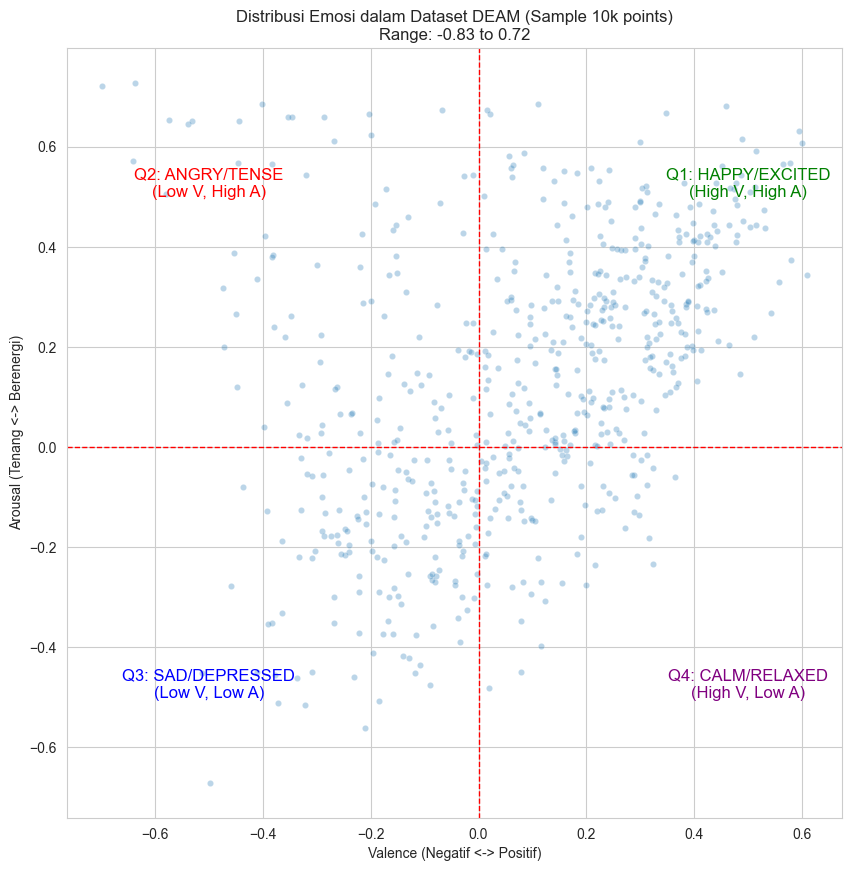

In [8]:
# Scatter Plot Valence vs Arousal
plt.figure(figsize=(10, 10))

# Scatter plot dengan transparansi agar terlihat densitasnya
sns.scatterplot(data=df_final.sample(10000), x='valence', y='arousal', alpha=0.3, s=20)

# Menambahkan garis kuadran (Titik tengah 0 atau 5 tergantung skala data)
# Cek range data dulu
min_val = df_final['valence'].min()
max_val = df_final['valence'].max()
mid_point = 0.0 # Asumsi data ternormalisasi -1 s.d 1 atau centered di 0

plt.axhline(y=mid_point, color='r', linestyle='--', linewidth=1)
plt.axvline(x=mid_point, color='r', linestyle='--', linewidth=1)

# Label Kuadran
plt.text(0.5, 0.5, "Q1: HAPPY/EXCITED\n(High V, High A)", fontsize=12, ha='center', color='green')
plt.text(-0.5, 0.5, "Q2: ANGRY/TENSE\n(Low V, High A)", fontsize=12, ha='center', color='red')
plt.text(-0.5, -0.5, "Q3: SAD/DEPRESSED\n(Low V, Low A)", fontsize=12, ha='center', color='blue')
plt.text(0.5, -0.5, "Q4: CALM/RELAXED\n(High V, Low A)", fontsize=12, ha='center', color='purple')

plt.title(f"Distribusi Emosi dalam Dataset DEAM (Sample 10k points)\nRange: {min_val:.2f} to {max_val:.2f}")
plt.xlabel("Valence (Negatif <-> Positif)")
plt.ylabel("Arousal (Tenang <-> Berenergi)")
plt.show()

## 5. Analisis Fitur Audio (Spectrogram)
Model CNN kita akan menerima input berupa gambar (**Mel-Spectrogram**). Mari kita lihat seperti apa bentuk visual dari sebuah lagu dalam dataset ini.

Menganalisis file: ../data/raw/audio\2.mp3


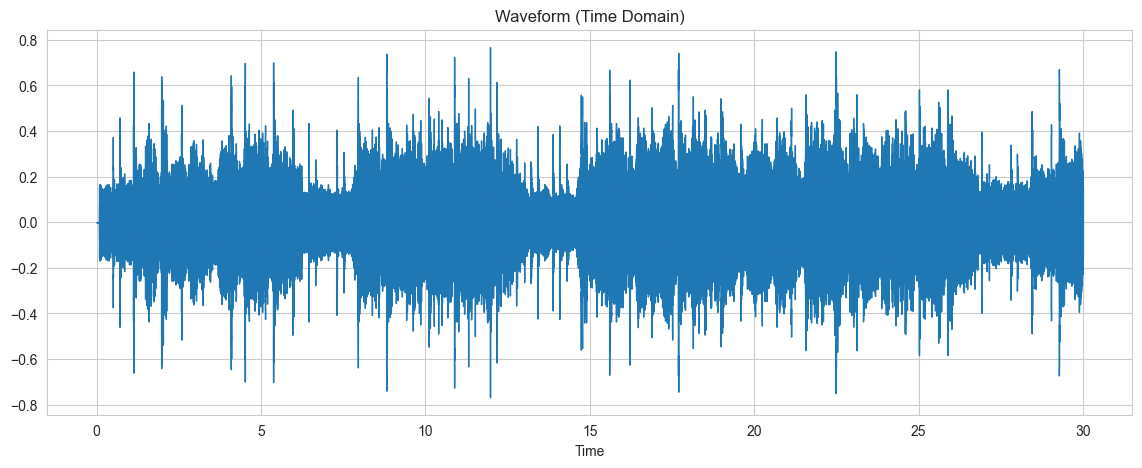

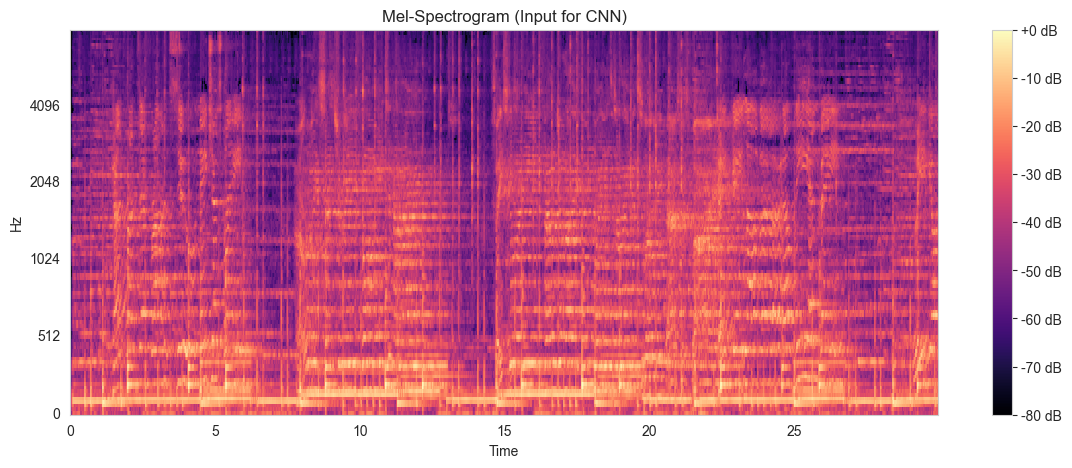

Max Amplitude: 0.767432689666748
Min Amplitude: -0.7432398796081543


In [16]:
# Ambil satu contoh lagu (pastikan file ada di folder)
sample_song_id = df_final['song_id'].iloc[0]
audio_path = os.path.join(PATH_AUDIO, f"{sample_song_id}.mp3")

if os.path.exists(audio_path):
    print(f"Menganalisis file: {audio_path}")
    
    # Load Audio (30 detik pertama saja untuk demo)
    y, sr = librosa.load(audio_path, sr=22050, duration=30)
    
    # 1. Tampilkan Waveform
    plt.figure(figsize=(14, 5))
    librosa.display.waveshow(y, sr=sr)
    plt.title("Waveform (Time Domain)")
    plt.show()
    
    # 2. Tampilkan Mel-Spectrogram
    plt.figure(figsize=(14, 5))
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    S_dB = librosa.power_to_db(S, ref=np.max)
    librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel-Spectrogram (Input for CNN)")
    plt.show()
    
    # Cek Statistik Sinyal (Mencegah file hening/rusak)
    print(f"Max Amplitude: {np.max(y)}")
    print(f"Min Amplitude: {np.min(y)}")
    if np.max(y) - np.min(y) == 0:
        print("WARNING: File ini hening total (Corrupt)!")
else:
    print(f"File {audio_path} tidak ditemukan. Cek path dataset.")

## 6. Kesimpulan & Strategi Project

Berdasarkan eksplorasi di atas, kita menyimpulkan strategi untuk **Data Pipeline**:

1. **Handling Intro:** Data label baru mulai tersedia di **15.000ms (Detik ke-15)**.
   * *Action:* Saat memotong audio, kita akan **membuang detik 0-15**.
   
2. **Segmentasi:** Untuk memperbanyak data latih dan menyesuaikan input CNN, lagu akan dipotong menjadi segmen kecil.
   * *Action:* Potong menjadi **3 detik** per segmen.
   
3. **Labeling:** Karena label tersedia per 500ms, kita akan mengambil rata-rata label dalam rentang 3 detik tersebut.
   * *Action:* `segment_label = mean(label_t, label_t+0.5, ..., label_t+3.0)`
   
4. **Data Cleaning:** Kita perlu memastikan tidak ada file audio yang *corrupt* (hening total) agar tidak merusak model (NaN loss).
   * *Action:* Tambahkan pengecekan `if max - min == 0` saat preprocessing.

---
*Langkah selanjutnya adalah membuat script `src/data_loader.py` untuk menjalankan strategi ini secara otomatis.*

In [29]:
# Cell Tambahan: Cek Integritas Audio Massal (Sample 50 file acak)
import glob

audio_files = glob.glob(os.path.join(PATH_AUDIO, "*.mp3"))
print(f"Total file audio di folder: {len(audio_files)}")

# Cek acak 50 file
sample_files = np.random.choice(audio_files, 50, replace=False)

print("Mengecek konsistensi durasi & sample rate...")
durations = []
srs = []

for f in sample_files:
    try:
        # get_duration lebih cepat daripada load full audio
         dur = librosa.get_duration(path=f)
         durations.append(dur)
         # Cek sr default
         srs.append(librosa.get_samplerate(f))
    except Exception as e:
        print(f"Error pada file {f}: {e}")

print(f"\nRata-rata Durasi: {np.mean(durations):.2f} detik")
print(f"Min Durasi: {np.min(durations):.2f} detik")
print(f"Sample Rates yang ditemukan: {set(srs)}")

if np.min(durations) < 30:
    print("WARNING: Ada file yang sangat pendek (< 30s). Perlu handling khusus!")
else:
    print("AMAN: Semua sampel memiliki durasi yang cukup.")

Total file audio di folder: 1802
Mengecek konsistensi durasi & sample rate...

Rata-rata Durasi: 47.75 detik
Min Durasi: 45.00 detik
Sample Rates yang ditemukan: {48000, 22050, 44100}
AMAN: Semua sampel memiliki durasi yang cukup.
